In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
import boto3 
import s3fs
import json
import datetime
from tzlocal import get_localzone as tzlocal
import numpy as np

In [2]:
import datetime
from tzlocal import get_localzone as tzlocal
import boto3
from tqdm import tqdm_notebook as tqdm

bucket_name = 'fog-bigdata-bmw-data'
s3_con = boto3.client('s3')
obj_list = s3_con.list_objects(Bucket=bucket_name,Prefix='metrics2/output')['Contents']
file_names = [key['Key'] for key in obj_list]

data = []
for file_name in tqdm(file_names):
    if not file_name.endswith('output.json'):
        continue
    file_str = s3_con.get_object(Bucket=bucket_name, Key=file_name).get('Body').read().decode('utf-8')
    batch = eval(file_str)
    if 'response-code-200' in batch.keys():
        data = data + batch['response-code-200']['Datapoints']

In [3]:
df = pd.DataFrame(data)
df = df.drop(columns=['Unit'])
df = df.groupby('Timestamp').sum()
series = pd.Series(data=df.SampleCount.values, index=[i.replace(tzinfo=None) for i in pd.to_datetime(df.index)])
series = series.sort_index()
data_freq = '5min'
series = series.groupby([pd.Grouper(freq=data_freq)]).sum()

# Apply a running mean to the last 15 minutes at each value
n_backsteps = 3
conv = np.hstack([np.ones(n_backsteps)/n_backsteps,np.zeros(n_backsteps-1)])
pad_vals = np.pad(series.values,n_backsteps-1,mode='edge')
series = pd.Series(data=np.convolve(pad_vals,conv,mode='valid'),index=series.index)

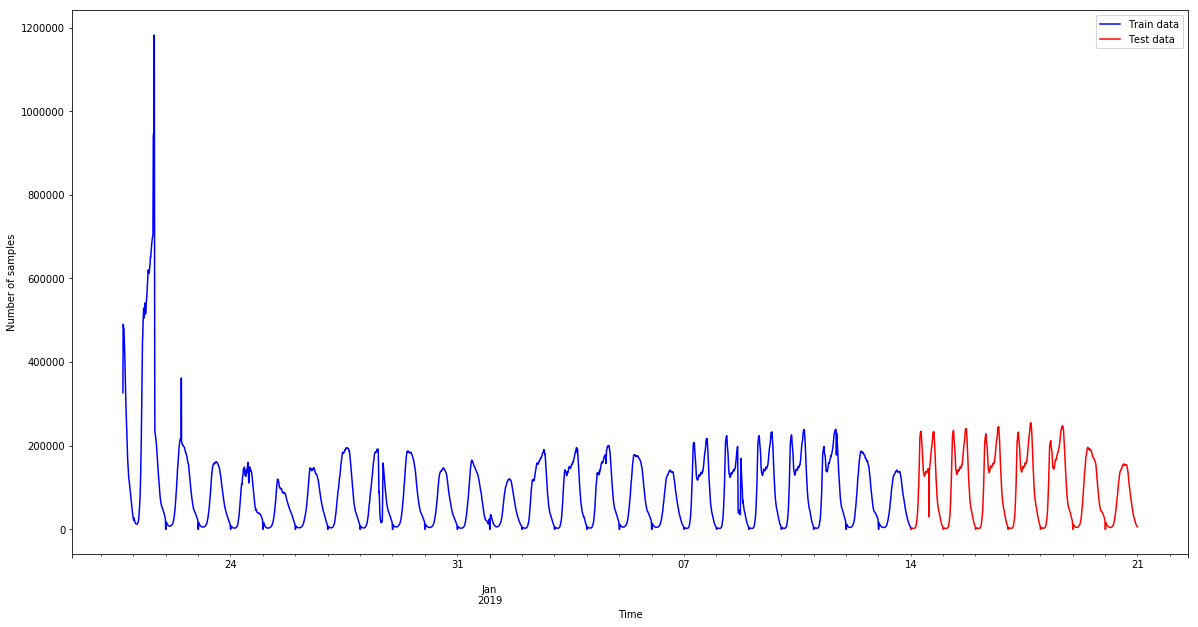

In [4]:
test_idx = (series.index > datetime.datetime(2019,1,14,0,0,0))
train_idx = np.logical_not(test_idx)
ax = series[train_idx].plot(
    figsize=(20,10),
    color='b',
    label='Train data'
)
series[test_idx].plot(
    figsize=(20,10),
    color='r',
    label='Test data',
    ax = ax
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xlabel('Time')
ax.set_ylabel('Number of samples');

In [5]:
# Upload preprocessed data for random cut forest

from os import path 

data_bucket_name = 'fog-datasets'
prefix = 'rcf'

s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/data.csv", 'w') as fp:
    fp.write(series[train_idx].to_csv())

with s3filesystem.open(s3_data_path + "/test/data.csv", 'w') as fp:
    fp.write(series[test_idx].to_csv())

In [6]:
import json
from deep_ar import series_to_jsonline

# Upload preprocessed data for deep AR
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

with s3filesystem.open(s3_data_path + "/train/data.json", 'w') as fp:
    fp.write(series_to_jsonline(series[train_idx]))

with s3filesystem.open(s3_data_path + "/test/data.json", 'w') as fp:
    fp.write(series_to_jsonline(series[test_idx]))

In [ ]:
import os

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
role = 'arn:aws:iam::746022503515:role/sage_maker'
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_output_path = "{}/{}/output".format(data_bucket_name, prefix)

train_locally = False

train_instance_type = 'local' if train_locally else 'ml.c4.xlarge'

if train_locally:
    print('Training locally...')

sagemaker_session = sagemaker.Session()

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

n_daily_datapoints = (60*24)//5

hyperparameters = dict(
    time_freq=data_freq,
    context_length=str(n_daily_datapoints),
    prediction_length=str(n_daily_datapoints),
    num_cells="40",
    num_layers="3",
    likelihood="gaussian",
    epochs="20",
    mini_batch_size="32",
    learning_rate="0.001",
    dropout_rate="0.05",
    early_stopping_patience="10"
)

estimator.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

In [10]:
# Create endpoint
from deep_ar import DeepARPredictor

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-01-22-14-09-59-078
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-01-22-14-09-59-078
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-01-22-14-09-59-078


-------------------------------------------------------------------------------------!

In [31]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)

predictor.set_prediction_parameters(data_freq, n_daily_datapoints * 7)

In [32]:
predictions = pd.DataFrame(predictor.predict([series[train_idx]])[0])

ValueError: Shape of passed values is (3, 288), indices imply (3, 2016)

In [ ]:
ax = series[train_idx].plot(
    figsize=(20,10),
    color='b',
    label='Train data'
)
series[test_idx].plot(
    figsize=(20,10),
    color='r',
    label='Test data (Ground truth)',
    ax = ax
)
predictions.plot(
    figsize=(20,10),
    color='green',
    label='Predictions',
    ax = ax
)